In [1]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
import lightgbm as lgb

import warnings 

pd.set_option('display.max_columns', 500)
warnings.filterwarnings(action = 'ignore')

# 1. Data Load

In [2]:
train_original = pd.read_csv('data/train.csv')
test_original = pd.read_csv('data/test.csv')
weather = pd.read_csv('data/weather_hour.csv', encoding = 'cp949')

train = train_original.copy()
test = test_original.copy()

**Time series 데이터의 경우 경향성이나 주기가 나타나므로 각 row의 시간정보를 세분화하여 column화**

In [3]:
def time_data (data) :

    data['Time'] = pd.to_datetime(data['Time'])

    data['day'] = data['Time'].dt.day
    data['month'] = data['Time'].dt.month
    data['year'] = data['Time'].dt.year
    data['hour'] = data['Time'].dt.hour
    data['weekday'] = data['Time'].dt.weekday
    data['weekend'] = 0
    
    for length in range(len(data)) : 
        if data['weekday'][length] > 4 :
            data['weekend'][length] = 1

    return data

In [4]:
train = time_data(train)
test = time_data(test)

# 2. Descriptive Statistics

**전력소모량과 다른 변수들의 특징 파악**  
**feature engineering 코드에서 날씨와 전력 소모량은 크게 상관이 없음을 확인**  
**따라서 날씨 데이터는 본 코드에서 사용 제외**

**전체적인 경향성을 파악하기 위해 Null값이 가장 적은 가구 추출**

In [5]:
def sort_null(data) : 
    null_count = [0] * (data.shape[1] -1)
    for length in range(data.shape[1] - 1) :
        null_count[length] = sum(data.iloc[ : , length + 1].isnull())
        
    column = data.columns[1 : ]
    null_counts = pd.DataFrame({'columns' :column, 
                                'null_count' : null_count})
    
    null_under_7500 = null_counts[null_counts['null_count'] < 7500]
    null_under_7500.sort_values(by = ['null_count'], inplace = True)
    
    return null_under_7500

In [6]:
least_null_house = sort_null(train_original)
least_null_house.head(10)

,columns,null_count
1184,NX1185,0
1174,NX1175,0
1043,NX1044,0
237,NX238,0
282,NX283,0
680,NX681,0
382,NX383,0
330,NX331,25
989,NX990,46
214,NX215,55


**Null 값이 하나도 존재하지 않는 가구는 총 7가구**  
**그 중 5개의 가구를 골라 이후 feature engineering에 활용**

*    NX1185
*    NX1175
*    NX283
*    NX681
*    NX383



In [7]:
selected_house = ['NX1185', 'NX1175', 'NX283', 'NX681', 'NX383']

### 전기 사용량 - 시간 상관관계

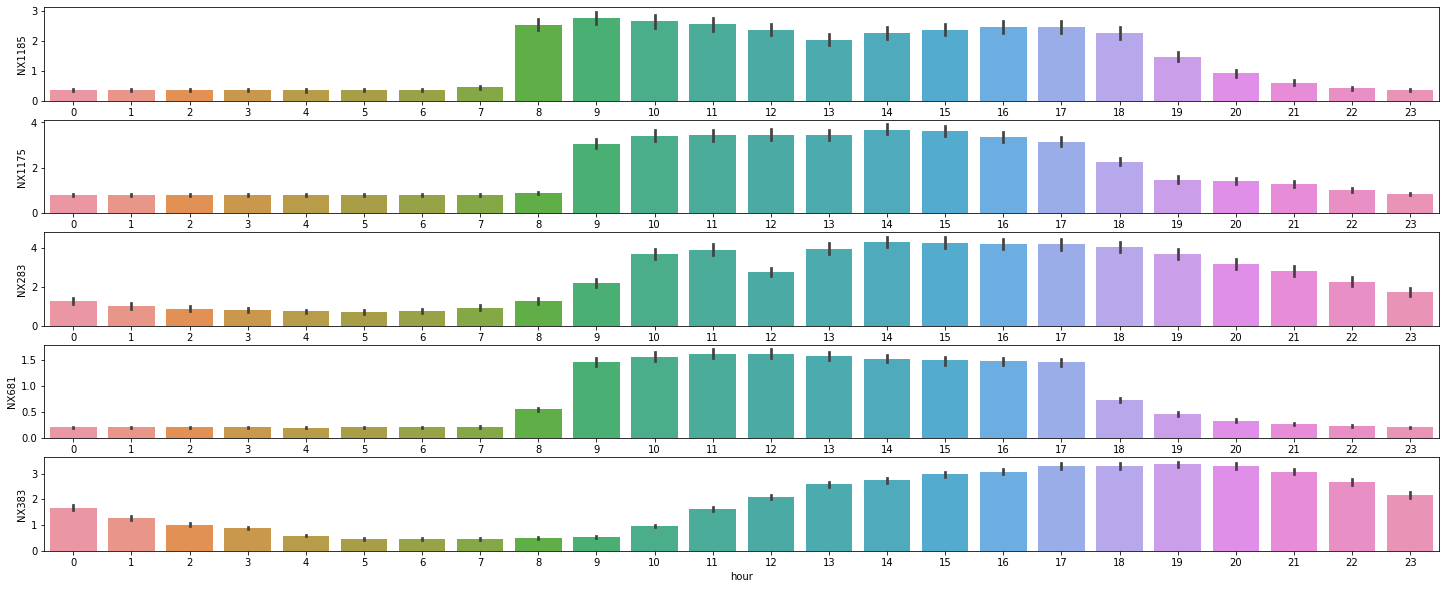

In [8]:
fig, ax = plt.subplots(5, 1, figsize = (25, 10))

for axes in range (5) :
    sns.barplot(x = train['hour'], y = train[selected_house[axes]], ax = ax[axes])
plt.show()

### 전기사용량 - 달 상관관계

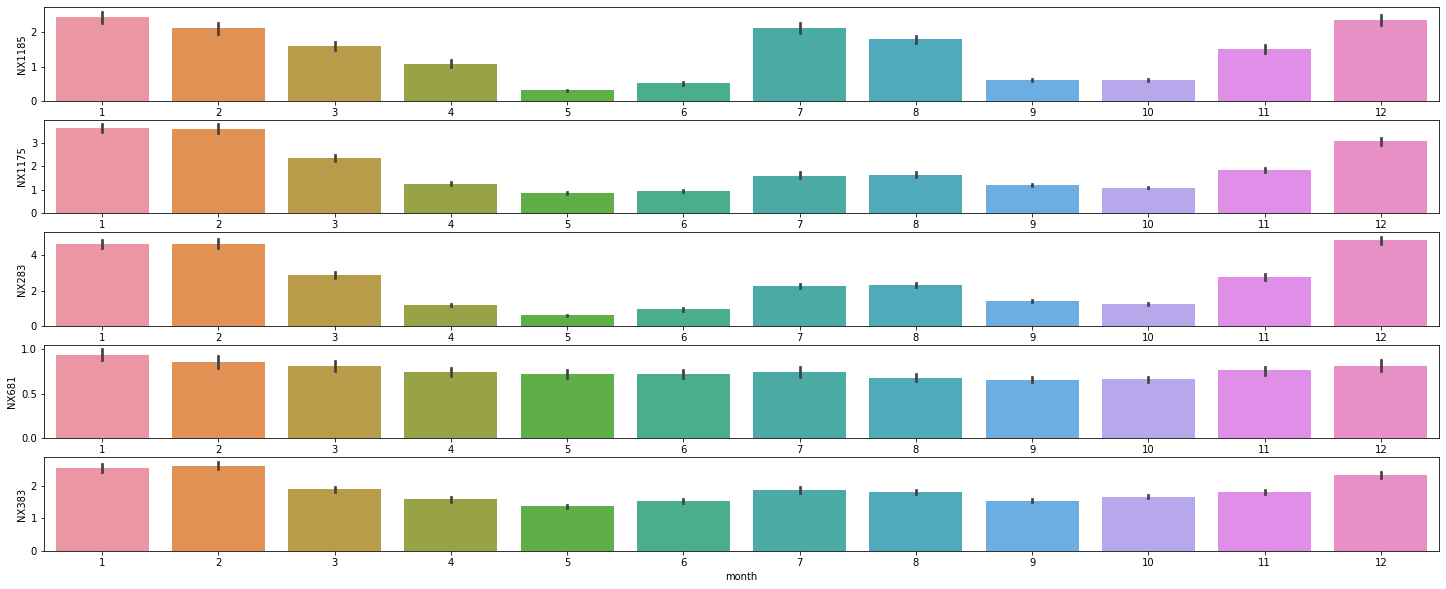

In [9]:
fig, ax = plt.subplots(5, 1, figsize = (25, 10))

for axes in range (5) :
    sns.barplot(x = train['month'], y = train[selected_house[axes]], ax = ax[axes])
plt.show()

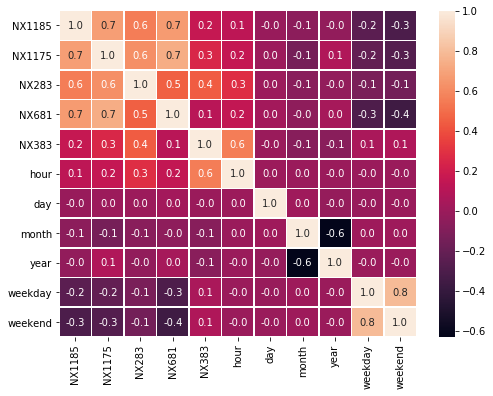

In [10]:
fig, ax = plt.subplots(1, 1, figsize = (8, 6))

selected_train = train[['NX1185', 'NX1175', 'NX283', 'NX681', 'NX383', 'hour', 'day', 'month', 'year', 'weekday', 'weekend']]
sns.heatmap(selected_train.corr(), annot = True, linewidths = 0.5, fmt = '.1f', ax = ax)
plt.show()

In [11]:
train_data = train.drop(['Time'], axis = 1)

**hour과 weekend가 상대적으로 높은 상관관계를 유지하고 있음**

# 3. Feature selection & model 구축

**ligthgbm algorithm을 사용**

In [13]:
print('train_data size is {}'.format(train_data.shape))
print('train and validaion data sizes are {0}, {1}'.format(train_data.shape[0]*0.8, train_data.shape[0]*0.2))

train_data size is (16909, 1306)
train and validaion data sizes are 13527.2, 3381.8


In [14]:
X_train = train_data.iloc[ : 1300, -6 : ]
X_test = train_data.iloc[1300 : , -6 :]
y_train = train_data.iloc[ : 1300, 1174]
y_test = train_data.iloc[1300 : , 1174]

create dataset for lightgbm

In [15]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0
}

In [18]:
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference = lgb_train)

In [19]:
print('Starting training...')
# train
    
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_eval,
                early_stopping_rounds=5)

print('Saving model...')
# save model to file
gbm.save_model('model.txt')

Starting training...
[1]	valid_0's l2: 5.86632	valid_0's l1: 1.38417
Training until validation scores don't improve for 5 rounds
[2]	valid_0's l2: 5.66901	valid_0's l1: 1.35312
[3]	valid_0's l2: 5.49655	valid_0's l1: 1.3261
[4]	valid_0's l2: 5.34627	valid_0's l1: 1.30167
[5]	valid_0's l2: 5.21351	valid_0's l1: 1.28008
[6]	valid_0's l2: 5.06999	valid_0's l1: 1.25988
[7]	valid_0's l2: 4.94352	valid_0's l1: 1.24723
[8]	valid_0's l2: 4.8264	valid_0's l1: 1.23671
[9]	valid_0's l2: 4.74788	valid_0's l1: 1.22954
[10]	valid_0's l2: 4.66075	valid_0's l1: 1.22247
[11]	valid_0's l2: 4.59505	valid_0's l1: 1.21549
[12]	valid_0's l2: 4.539	valid_0's l1: 1.20978
[13]	valid_0's l2: 4.46719	valid_0's l1: 1.20382
[14]	valid_0's l2: 4.42769	valid_0's l1: 1.19982
[15]	valid_0's l2: 4.39484	valid_0's l1: 1.19668
[16]	valid_0's l2: 4.36362	valid_0's l1: 1.19379
[17]	valid_0's l2: 4.32073	valid_0's l1: 1.19033
[18]	valid_0's l2: 4.30075	valid_0's l1: 1.18852
[19]	valid_0's l2: 4.2713	valid_0's l1: 1.18616
[2

In [29]:
print('Starting predicting...')
# predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
# eval
print('The rmse of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)

Starting predicting...
The rmse of prediction is: 2.0608792670955087


In [34]:
NX_1 = pd.DataFrame(y_pred, y_test)
NX_1.to_csv('output.csv')